In [1]:
#Eureka Energies
#Estimates the return energies from the air-snow and snow-ice interfaces based on the roughnesses of the two interfaces
# Claude de Rijke-Thomas
#last modified: 9th May 2022 

In [44]:
icetype = 'myi' #the ice type that we want to be investigating (can either be fyi or myi)
saving = False
from LPS_functions import *

In [45]:
#initialising empty arrays:
lat = np.array([], dtype='double')
lon = np.array([], dtype='double')
b_as = np.array([],dtype='int')
b_si = np.array([], dtype='int')
snow_depth_dot_n = np.array([], dtype='double')

insitu_data_filepath = '/Users/claudederijkethomas/Desktop/PhD/PYTHON/OIB/'\
                        +'19-21Apr2016/SR/insitu_data_eureka.csv'

#opening the csv file to read through (to make a loading bar of progress):
line_count=0
with open(insitu_data_filepath, 'r') as csvfile:
    readCSV = csv.DictReader(csvfile)
    #establishing the headers as the first line of the file:
    headers = readCSV.fieldnames
    for line in readCSV:
        line_count+=1        
#Timestamp,Counter,DepthCm,Latitude,Longitude,Site,IceType are the headers
Timestamp = np.array([], dtype='str')
Counter = np.array([], dtype='int')
DepthCm = np.array([], dtype='double')
Latitude = np.array([], dtype='double')
Longitude = np.array([], dtype='double')
Site = np.array([], dtype='str')
IceType = np.array([], dtype='str')

with open(insitu_data_filepath, 'r') as csvfile:
    readCSV = csv.DictReader(csvfile)
    #establishing the headers as the first line of the file:
    headers = readCSV.fieldnames
    count=-1
    for line in readCSV:
        count+=1
        if count%1000==0:
            sys.stdout.write("\r"+str(100*count/line_count)+"% of the way ")
        if str(line['Timestamp'][0:2]).isdigit():
            if int(line['Timestamp'][0:2])>=15: # if data is taken on the 15th or later
                if str(line['IceType'])==icetype:
                    Timestamp = np.append(Timestamp, str(line['Timestamp']))
                    Counter = np.append(Counter, int(line['Counter']))
                    DepthCm = np.append(DepthCm, float(line['DepthCm']))
                    Latitude = np.append(Latitude, float(line['Latitude']))
                    Longitude = np.append(Longitude, float(line['Longitude']))
                    Site = np.append(Site, str(line['Site']))
                    IceType = np.append(IceType, str(line['IceType']))

    sys.stdout.write("\r"+"100% complete                 ")

100% complete                  

In [46]:
insitu_xs, insitu_ys = easeProj(Longitude,Latitude)
insitu_kdtree = spatial.cKDTree(np.column_stack((insitu_xs, insitu_ys)))


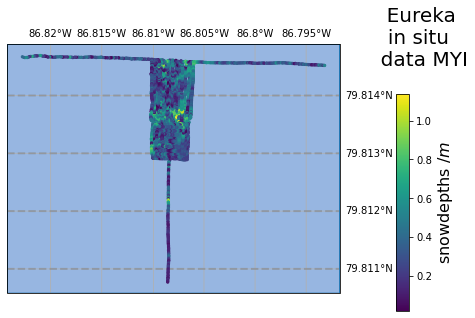

In [47]:
fig = plt.figure()

central_lon,central_lat = np.mean(Longitude),np.mean(Latitude)
ax = fig.add_axes([0,0,0.77,1], projection=ccrs.Orthographic(central_lon,central_lat))
scat = ax.scatter(Longitude,Latitude,s=5,c=DepthCm,transform=ccrs.PlateCarree(), zorder=3)
ax.gridlines()
cbar_ax = fig.add_axes([0.90, 0.007, 0.03, 0.753]) #start xpos, start ypos, #xwidth, ylendth
cbar_ax.set_title("       Eureka \n     in situ\n       data "+str(icetype).upper()+"\n",fontsize=20)
lol = cbar_ax.scatter(x=np.zeros(len(DepthCm)),y=np.zeros(len(DepthCm)),c=DepthCm/100)
cb = fig.colorbar(lol, cax=cbar_ax)
cb.set_label('snowdepths $/m$', size=16)

ax.coastlines(resolution='50m')
ocean110 = cartopy.feature.NaturalEarthFeature('physical', 'ocean', \
    scale='50m', edgecolor='none', facecolor=cartopy.feature.COLORS['water'])
ax.add_feature(ocean110)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.bottom_labels = False
gl.top_labels = True
gl.left_labels = False
gl.xlines = False

xlims = ax.get_xlim()
ylims = ax.get_ylim()

extent_lonlat = ax.get_extent(crs=ccrs.PlateCarree())

dataExtentPolygon = Polygon([(extent_lonlat[0],extent_lonlat[2]),\
                             (extent_lonlat[1],extent_lonlat[2]),\
                             (extent_lonlat[1],extent_lonlat[3]),\
                             (extent_lonlat[0],extent_lonlat[3])])
ax.plot(*dataExtentPolygon.exterior.xy,transform=ccrs.PlateCarree())

ax.set_extent(extent_lonlat,crs=ccrs.PlateCarree())
plt.show()

In [48]:
if icetype=='fyi':
    coincident_ku_files = ['IRKUB1B_20160419_04_004_deconv.nc', 'IRKUB1B_20160419_04_032_deconv.nc', 'IRKUB1B_20160419_04_050_deconv.nc', 'IRKUB1B_20160419_04_080_deconv.nc', 'IRKUB1B_20160419_04_180_deconv.nc', 'IRKUB1B_20160419_04_208_deconv.nc', 'IRKUB1B_20160419_04_230_deconv.nc', 'IRKUB1B_20160419_04_258_deconv.nc', 'IRKUB1B_20160419_04_259_deconv.nc']
elif icetype=='myi':
    coincident_ku_files = ['IRKUB1B_20160419_04_035_deconv.nc', 'IRKUB1B_20160419_04_047_deconv.nc', 'IRKUB1B_20160419_04_083_deconv.nc', 'IRKUB1B_20160419_04_176_deconv.nc', 'IRKUB1B_20160419_04_211_deconv.nc', 'IRKUB1B_20160419_04_226_deconv.nc', 'IRKUB1B_20160419_04_262_deconv.nc']

In [49]:
"""Making an overlapping KDTree of all the atm data from all of the flyovers"""
all_overlapping_h5_files = []
for ku_file in coincident_ku_files:
    for coinc in coincidence_arr:
        for sub_arr in coinc:
            if ku_file in sub_arr:
                #finding the kdtree that corresponds to the atm laser data file that coincides with ku_file:
                all_overlapping_h5_files.append(coinc[0])
                ku_files = coinc[1]
#making sure that I dont accidentally count the same file twice:
all_overlapping_h5_files = list(dict.fromkeys(all_overlapping_h5_files))
atm_laser = projectedLaser(all_overlapping_h5_files, "ease")
x_atm_laser,y_atm_laser = atm_laser.east, atm_laser.north

overlapping_kdtree = spatial.cKDTree(np.column_stack((x_atm_laser, y_atm_laser)))

In [50]:
"""using the ATM laser file offsets to align each ATM laser file to each other (each ATM file has an altimetric offset relative to the others
 determined by its mean patch offset, relative to the overall mean patch elevation of the ATM laser files combined).
 These offsets are calculated in Eureka_ATM_laser_Offsets.ipynb"""
if icetype == 'fyi':
    #this is  mean_atm_elev_each_flyover - np.mean(mean_atm_elev_each_flyover)
    atm_elev_flyover_offsets = [-0.00142218, -0.00882589, -0.0182781, -0.01468046, -0.06314833, 0.0375774, 0.02246962, 0.02315396, 0.02315396] #for first year ice!!!!
elif icetype == 'myi':
    atm_elev_flyover_offsets = [-0.01541401, -0.02724434, -0.00367711, -0.05813091, 0.03078281, 0.03742214, 0.03626142]
all_overlapping_atm_alts_arr = np.array([],dtype='double')
for i,ku_file in enumerate(coincident_ku_files):
    h5_files = []
    for coinc in coincidence_arr:
        for sub_arr in coinc:
            if ku_file in sub_arr:
                #finding the kdtree that corresponds to the atm laser data file that coincides with ku_file:
                h5_files.append(coinc[0])
                ku_files = coinc[1]
    atm = projectedLaser(h5_files, "ease")
    all_overlapping_atm_alts_arr = np.append(all_overlapping_atm_alts_arr, atm.alt - atm_elev_flyover_offsets[i])
    
#overriding the atm altitudes to compensate for the offsets between the atm files:
atm_laser.alt = all_overlapping_atm_alts_arr

In [51]:
offset_list_2D = []
angle_thresh=3

for ku_file_counter, ku_file in enumerate(coincident_ku_files):
    offset_list_file = []
    x_ku,y_ku,alt_ku, pitch_ku, roll_ku, aircraft_alt_ku, azi_angle, appropriate_indices = correctEastNorthKu(ku_file, coord_sys="ease")
    ku_subpath = "ku/"
    try:
        nc = netCDF4.Dataset(ku_file) #making an nc file in the format that Python can understand
    except FileNotFoundError:
        try:
            nc = netCDF4.Dataset(ku_subpath+ku_file)
        except FileNotFoundError:
            nc = netCDF4.Dataset(ku_path+ku_file)
    log_amplitude = nc['amplitude'][appropriate_indices] #a 2-D array of stacked waveforms, with the first index being waveform number 
                                    #and the second being the range bin number of a particular waveform. 
                                  #Contains log-amplitude waveform data
                                    #Shape = [number of waveforms x number of range bins in each waveform]
    fasttime_ku = nc['fasttime'][:]
    j=-1
    for footprint, footprint_data in footprintDataYielder(x_ku, y_ku, alt_ku, pitch_ku, roll_ku, aircraft_alt_ku, azi_angle, atm_laser.coords, overlapping_kdtree):
        j+=1
        #the altitudes of the ATM data within a particular ku footprint:
        atm_alts_within = [atm_laser.alt[datum] for datum in footprint_data]
        #the rolls of the ATM data within a particular ku footprint:
        atm_rolls_within = [atm_laser.roll[datum] for datum in footprint_data]
        atm_pitches_within = [atm_laser.pitch[datum] for datum in footprint_data]
        if len(atm_alts_within)>0 and \
        abs(roll_ku[j]*180/np.pi)<angle_thresh and \
        abs(pitch_ku[j]*180/np.pi)<angle_thresh and \
        all(abs(atm_roll*180/np.pi)<angle_thresh for atm_roll in atm_rolls_within) and \
        all(abs(atm_pitch*180/np.pi)<angle_thresh for atm_pitch in atm_pitches_within):
            unlog_amp = 10**(np.array(log_amplitude[j])/10)
            try:
                offset_list_file.append(np.nanmean(atm_alts_within) - Waveform(unlog_amp,fasttime_ku,footprint_atm_alts = atm_alts_within,aircraft_alt=aircraft_alt_ku[j]).estimated_air_snow_alt)
            except:
                print(Waveform(unlog_amp,fasttime_ku,footprint_atm_alts = atm_alts_within,aircraft_alt=aircraft_alt_ku[j]).estimated_air_snow_alt)
                offset_list_file.append(np.nanmean(atm_alts_within) - Waveform(unlog_amp,fasttime_ku,footprint_atm_alts = atm_alts_within,aircraft_alt=aircraft_alt_ku[j]).estimated_air_snow_alt)
                raise

    offset_list_2D.append(offset_list_file)

[ 0.07708323  0.07671809  0.039888    0.00644744 -0.02853764 -0.00534176
 -0.0180985 ]
[0.07180564 0.08564682 0.10897266 0.11788031 0.08795264 0.09404222
 0.09688887]
[508. 636. 544. 520. 509. 492. 518.]


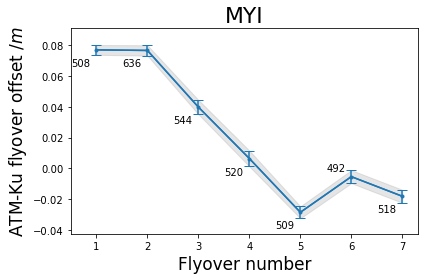

In [52]:
atm_ku_flyover_offset_means = np.full(len(offset_list_2D),np.nan, dtype='double')
atm_ku_flyover_offset_lens = np.full(len(offset_list_2D),np.nan, dtype= 'double')
atm_ku_flyover_offset_stds = np.full(len(offset_list_2D),np.nan, dtype='double')
atm_ku_flyover_offset_stes = np.full(len(offset_list_2D),np.nan, dtype='double')
for i, file_offsets in enumerate(offset_list_2D):
#     if i==1:
#         pass
#         p(len(np.array(file_offsets)[~np.isnan(file_offsets)]))
    atm_ku_flyover_offset_means[i] = np.nanmean(file_offsets)
    atm_ku_flyover_offset_stds[i] = np.nanstd(file_offsets, ddof=1)
    atm_ku_flyover_offset_stes[i] = np.nanstd(file_offsets, ddof=1)/np.sqrt(len(np.array(file_offsets)[~np.isnan(file_offsets)]))
    atm_ku_flyover_offset_lens[i] = len(np.array(file_offsets)[~np.isnan(file_offsets)])
#         print(np.nanmax(file_offsets))

print(atm_ku_flyover_offset_means)
print(atm_ku_flyover_offset_stds)
print(atm_ku_flyover_offset_lens)
errorPlot(range(1,len(atm_ku_flyover_offset_means)+1),atm_ku_flyover_offset_means, atm_ku_flyover_offset_stes, point_labels=atm_ku_flyover_offset_lens)
plt.xticks(range(1,len(atm_ku_flyover_offset_means)+1))
plt.ylabel("ATM-Ku flyover offset $/m$",fontsize=17)
plt.xlabel("Flyover number",fontsize=17)
plt.title(icetype.upper(), fontsize=22)
plt.tight_layout()
# plt.savefig("plots/ATMKuFlyoverOffsets.png", dpi=200)

#uncomment this line if you want a global offset instead of a file-by-file offset:
# atm_ku_flyover_offset_means[:] = np.nanmean(fflat(offset_list_2D))

In [53]:
angle_thresh=3

snowice_interp_unlog_amps = np.array([],dtype='double')

airsnow_interp_unlog_amps = np.array([],dtype='double')

closest_peak_amps_to_airsnow_interp_range_bin = np.array([],dtype='double')
closest_peak_amps_to_snowice_interp_range_bin = np.array([],dtype='double')

footprint_alts_stds = np.array([],dtype='double')

airsnow_stds_within_10m = np.array([],dtype='double')
snowice_stds_within_10m = np.array([],dtype='double')

footprints_insitu_snowdepths = np.array([],dtype='double')

for ku_file_counter, ku_file in enumerate(coincident_ku_files):

    x_ku,y_ku,alt_ku, pitch_ku, roll_ku, aircraft_alt_ku, azi_angle, appropriate_indices = correctEastNorthKu(ku_file, coord_sys="ease")
    ku_subpath = "ku/"
    try:
        nc = netCDF4.Dataset(ku_file) #making an nc file in the format that Python can understand
    except FileNotFoundError:
        try:
            nc = netCDF4.Dataset(ku_subpath+ku_file)
        except FileNotFoundError:
            nc = netCDF4.Dataset(ku_path+ku_file)
    log_amplitude = nc['amplitude'][appropriate_indices] #a 2-D array of stacked waveforms, with the first index being waveform number 
                                    #and the second being the range bin number of a particular waveform. 
                                  #Contains log-amplitude waveform data
                                    #Shape = [number of waveforms x number of range bins in each waveform]
    fasttime_ku = nc['fasttime'][:]
    # print(np.shape(fasttime_ku))
    # print(fasttime_ku[0:30])
    j=-1
    for footprint_poly, footprint_data in footprintDataYielder(x_ku, y_ku, alt_ku, pitch_ku, roll_ku, aircraft_alt_ku, azi_angle, atm_laser.coords, overlapping_kdtree):
        j+=1
        #the altitudes of the ATM data within a particular ku footprint:
        atm_alts_within = [atm_laser.alt[datum] for datum in footprint_data]
        #the rolls of the ATM data within a particular ku footprint:
        atm_rolls_within = [atm_laser.roll[datum] for datum in footprint_data]
        atm_pitches_within = [atm_laser.pitch[datum] for datum in footprint_data]
        if len(atm_alts_within)>0 and \
        abs(roll_ku[j]*180/np.pi)<angle_thresh and \
        abs(pitch_ku[j]*180/np.pi)<angle_thresh and \
        all(abs(atm_roll*180/np.pi)<angle_thresh for atm_roll in atm_rolls_within) and \
        all(abs(atm_pitch*180/np.pi)<angle_thresh for atm_pitch in atm_pitches_within):
            footprint_alts_stds = np.append(footprint_alts_stds, np.std(atm_alts_within,ddof=1))
            "remember I need to include the ATM-Ku offsets as well as I'm working with altitudes"
            indices_of_insitu_points_within_5m_of_footprint_centre = insitu_kdtree.query_ball_point([x_ku[j], y_ku[j]], r=5)
            indices_of_atm_points_within_10m_of_footprint_centre = overlapping_kdtree.query_ball_point([x_ku[j], y_ku[j]], r=10)
            footprint_insitu_snowdepths = np.array([],dtype='double')
            for i in indices_of_insitu_points_within_5m_of_footprint_centre:
                if footprint_poly.contains(Point(insitu_xs[i],insitu_ys[i])):
                    footprint_insitu_snowdepths = np.append(footprint_insitu_snowdepths,DepthCm[i]/100)
            if np.any(footprint_insitu_snowdepths):
                atm_indices_for_atm_insitu_estimated_snowice_interface_alts = np.array([],dtype='int')
                
                indices_of_atm_points_within_10m_of_footprint_centre = overlapping_kdtree.query_ball_point([x_ku[j], y_ku[j]], r=10)
                indices_of_insitu_points_within_10m_of_footprint_centre = insitu_kdtree.query_ball_point([x_ku[j], y_ku[j]], r=10)
                
                """trying to find if multiple ATM laser points within a 10m radius circle have really closeby in situ data (within 10cm)"""    
                nearby_atm_and_insitu_within_10m_counter = 0
                atm_insitu_estimated_snowice_interface_alts = np.array([],dtype='double')
                atm_estimated_airsnow_interface_alts = np.array([], dtype='double')

                #looping over the in situ and atm laser points that are within 10m of a particular ku SAR footprint centre::
                if len(indices_of_insitu_points_within_10m_of_footprint_centre)>0 and len(indices_of_atm_points_within_10m_of_footprint_centre)>0:
                    for insitu_index in indices_of_insitu_points_within_10m_of_footprint_centre:
                        corresponding_atm_index_found = False
                        for atm_index in indices_of_atm_points_within_10m_of_footprint_centre:
                            #finding the in situ data within 10cm of the ATM laser spot:
                            if (insitu_xs[insitu_index] - x_atm_laser[atm_index])**2.0 + (insitu_ys[insitu_index] - y_atm_laser[atm_index])**2.0 < 0.04 \
                                                                                                            and not corresponding_atm_index_found:
                                nearby_atm_and_insitu_within_10m_counter+=1
                                #calculating the altitude of the sea ice interface by subtracking the in situ snowdepths 10cm close to atm laser data from the atm laser altitudes:
                                atm_insitu_estimated_snowice_interface_alts = np.append(atm_insitu_estimated_snowice_interface_alts, \
                                                                                        atm_laser.alt[atm_index] - DepthCm[insitu_index]/100)
                                #if I'm trying to find the correlation between the roughness of the air-snow interface and the snow-ice interface
                                #then I shouldnt be using the same atm points for this:
                                atm_indices_for_atm_insitu_estimated_snowice_interface_alts = np.append(atm_indices_for_atm_insitu_estimated_snowice_interface_alts, atm_index)
                                corresponding_atm_index_found = True
                                the_corresponding_atm_index = atm_index  
                            
                if len(atm_insitu_estimated_snowice_interface_alts)>=2: #at this point in code, we know that there's enough data to calculate a s.d. of both sea ice and snow for the
                                                                #footprint, however, we dont know whether there is coincident ATM laser data within the Ku footprint 
                                                                #(which is what our method relies on, so we should make sure we have that next)
                                                                #oh wait actually we do becasue that was one of the criteria above where the pitch and roll is^^^^^^^^^^^^^^
                                                                #therefore, these footprints are viable for our calculations and comparisons 
                                                                #IF there's insitu snowdepths within the footprint:
                            
                    snowice_std_within_10m = np.std(atm_insitu_estimated_snowice_interface_alts,ddof=1)
                    snowice_stds_within_10m = np.append(snowice_stds_within_10m, snowice_std_within_10m)
                    
                    not_already_used_indices_of_atm_points_within_10m_of_footprint_centre =\
                                        np.array(list(filter(lambda x: x not in atm_indices_for_atm_insitu_estimated_snowice_interface_alts, \
                                        indices_of_atm_points_within_10m_of_footprint_centre)), dtype='int')

                    airsnow_std_within_10m = np.std(atm_laser.alt[not_already_used_indices_of_atm_points_within_10m_of_footprint_centre], ddof=1)
                    airsnow_stds_within_10m = np.append(airsnow_stds_within_10m, airsnow_std_within_10m)
                    
                    footprints_insitu_snowdepths = np.append(footprints_insitu_snowdepths, np.mean(footprint_insitu_snowdepths))
                    
                    atm_derived_alt_of_airsnow_interface = np.mean(atm_alts_within)
                    atm_insitu_derived_alt_of_snowice_interface = np.mean(atm_alts_within) - np.mean(footprint_insitu_snowdepths)

                    #converting the altitudes of the atm-insitu derived air-snow and snow-ice interfaces into interpolated range bin numbers
                    #(so that I can estimate the amplitudes of the air-snow and snow-ice interfaces)::::
                    arr_of_ku_alts_from_fasttimes = aircraft_alt_ku[j] + atm_ku_flyover_offset_means[ku_file_counter] - (np.array(fasttime_ku)*10**-6/2) * 299792458
                    #np.interp assumes monotonically increasing, whereas we want monotonically decreasing in altitude (corresponding to increasing range bins) 
                    #so we need to do some subsequent rearranging:::
                    arr_of_ku_alts_from_fasttimes_flipped = np.flip(arr_of_ku_alts_from_fasttimes)
                    airsnow_interp_range_bin, snowice_interp_range_bin = np.interp([atm_derived_alt_of_airsnow_interface,atm_insitu_derived_alt_of_snowice_interface],arr_of_ku_alts_from_fasttimes_flipped, \
                                        np.arange(len(fasttime_ku)-1,-1,-1))
                    unlog_amp = 10**(np.array(log_amplitude[j])/10)


                    preliminary_start_of_signal  = [i for i,v in enumerate(unlog_amp) if v > np.mean(unlog_amp[:250])+6*np.std(unlog_amp[:250], ddof=1)][10]
                    i = preliminary_start_of_signal
                    while unlog_amp[i]>np.mean(unlog_amp[:250])+2.5*np.std(unlog_amp[:250], ddof=1):
                        i-=1
                    start_of_signal=i                
                    peak_indices, peak_dict = find_peaks(unlog_amp/simps(unlog_amp[start_of_signal:start_of_signal+250]), height=0.002) #finding all the indices of all the peaks in the echo
                    closest_peak_index_to_airsnow_interp_range_bin = peak_indices[np.argmin(abs(peak_indices - airsnow_interp_range_bin))]
                    closest_peak_index_to_snowice_interp_range_bin = peak_indices[np.argmin(abs(peak_indices - snowice_interp_range_bin))]
                    if closest_peak_index_to_airsnow_interp_range_bin!=closest_peak_index_to_snowice_interp_range_bin:
                        closest_peak_amps_to_airsnow_interp_range_bin = np.append(closest_peak_amps_to_airsnow_interp_range_bin, unlog_amp[closest_peak_index_to_airsnow_interp_range_bin])
                        closest_peak_amps_to_snowice_interp_range_bin = np.append(closest_peak_amps_to_snowice_interp_range_bin, unlog_amp[closest_peak_index_to_snowice_interp_range_bin])
                    airsnow_interp_unlog_amp, snowice_interp_unlog_amp = np.interp([airsnow_interp_range_bin, snowice_interp_range_bin], range(len(fasttime_ku)), unlog_amp)
                    airsnow_interp_unlog_amps = np.append(airsnow_interp_unlog_amps, airsnow_interp_unlog_amp)
                    snowice_interp_unlog_amps = np.append(snowice_interp_unlog_amps, snowice_interp_unlog_amp)

261
261
0.029045758468901936
0.044990609796739134


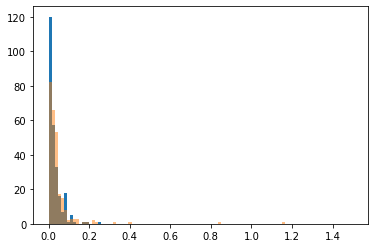

In [54]:
# print(len(airsnow_interp_unlog_amps))
print(len(airsnow_stds_within_10m))
print(len(snowice_stds_within_10m))
plt.hist(airsnow_interp_unlog_amps*airsnow_stds_within_10m, bins=np.linspace(0,1.5,100));
plt.hist(snowice_interp_unlog_amps*snowice_stds_within_10m, bins=np.linspace(0,1.5,100), alpha=0.5);
print(np.mean(airsnow_interp_unlog_amps*airsnow_stds_within_10m))
print(np.mean(snowice_interp_unlog_amps*snowice_stds_within_10m))

In [55]:
angle_thresh=3

snowice_interp_unlog_amps = np.array([],dtype='double')
airsnow_interp_unlog_amps = np.array([],dtype='double')

closest_peak_amps_to_airsnow_interp_range_bin = np.array([],dtype='double')
closest_peak_amps_to_snowice_interp_range_bin = np.array([],dtype='double')

footprint_alts_stds = np.array([],dtype='double')

airsnow_stds_within_5m = np.array([],dtype='double')
snowice_stds_within_5m = np.array([],dtype='double')

footprints_insitu_snowdepths = np.array([],dtype='double')


for ku_file_counter, ku_file in enumerate(coincident_ku_files):

    x_ku,y_ku,alt_ku, pitch_ku, roll_ku, aircraft_alt_ku, azi_angle, appropriate_indices = correctEastNorthKu(ku_file, coord_sys="ease")
    ku_subpath = "ku/"
    try:
        nc = netCDF4.Dataset(ku_file) #making an nc file in the format that Python can understand
    except FileNotFoundError:
        try:
            nc = netCDF4.Dataset(ku_subpath+ku_file)
        except FileNotFoundError:
            nc = netCDF4.Dataset(ku_path+ku_file)
    log_amplitude = nc['amplitude'][appropriate_indices] #a 2-D array of stacked waveforms, with the first index being waveform number 
                                    #and the second being the range bin number of a particular waveform. 
                                  #Contains log-amplitude waveform data
                                    #Shape = [number of waveforms x number of range bins in each waveform]
    fasttime_ku = nc['fasttime'][:]
    # print(np.shape(fasttime_ku))
    # print(fasttime_ku[0:30])
    j=-1
    for footprint_poly, footprint_data in footprintDataYielder(x_ku, y_ku, alt_ku, pitch_ku, roll_ku, aircraft_alt_ku, azi_angle, atm_laser.coords, overlapping_kdtree):
        j+=1
        #the altitudes of the ATM data within a particular ku footprint:
        atm_alts_within = [atm_laser.alt[datum] for datum in footprint_data]
        #the rolls of the ATM data within a particular ku footprint:
        atm_rolls_within = [atm_laser.roll[datum] for datum in footprint_data]
        atm_pitches_within = [atm_laser.pitch[datum] for datum in footprint_data]
        if len(atm_alts_within)>0 and \
        abs(roll_ku[j]*180/np.pi)<angle_thresh and \
        abs(pitch_ku[j]*180/np.pi)<angle_thresh and \
        all(abs(atm_roll*180/np.pi)<angle_thresh for atm_roll in atm_rolls_within) and \
        all(abs(atm_pitch*180/np.pi)<angle_thresh for atm_pitch in atm_pitches_within):
            footprint_alts_stds = np.append(footprint_alts_stds, np.std(atm_alts_within,ddof=1))
            "remember I need to include the ATM-Ku offsets as well as I'm working with altitudes"
            indices_of_insitu_points_within_5m_of_footprint_centre = insitu_kdtree.query_ball_point([x_ku[j], y_ku[j]], r=5)
            indices_of_atm_points_within_5m_of_footprint_centre = overlapping_kdtree.query_ball_point([x_ku[j], y_ku[j]], r=5)
            footprint_insitu_snowdepths = np.array([],dtype='double')
            for i in indices_of_insitu_points_within_5m_of_footprint_centre:
                if footprint_poly.contains(Point(insitu_xs[i],insitu_ys[i])):
                    footprint_insitu_snowdepths = np.append(footprint_insitu_snowdepths,DepthCm[i]/100)
            if np.any(footprint_insitu_snowdepths):
                atm_indices_for_atm_insitu_estimated_snowice_interface_alts = np.array([],dtype='int')
                
                indices_of_atm_points_within_5m_of_footprint_centre = overlapping_kdtree.query_ball_point([x_ku[j], y_ku[j]], r=5)
                indices_of_insitu_points_within_5m_of_footprint_centre = insitu_kdtree.query_ball_point([x_ku[j], y_ku[j]], r=5)
                
                """trying to find if multiple ATM laser points within a 5m radius circle have really closeby in situ data (within 10cm)"""    
                nearby_atm_and_insitu_within_5m_counter = 0
                atm_insitu_estimated_snowice_interface_alts = np.array([],dtype='double')
                atm_estimated_airsnow_interface_alts = np.array([], dtype='double')

                #looping over the in situ and atm laser points that are within 5m of a particular ku SAR footprint centre::
                if len(indices_of_insitu_points_within_5m_of_footprint_centre)>0 and len(indices_of_atm_points_within_5m_of_footprint_centre)>0:
                    for insitu_index in indices_of_insitu_points_within_5m_of_footprint_centre:
                        corresponding_atm_index_found = False
                        for atm_index in indices_of_atm_points_within_5m_of_footprint_centre:
                            #finding the in situ data within 10cm of the ATM laser spot:
                            if (insitu_xs[insitu_index] - x_atm_laser[atm_index])**2.0 + (insitu_ys[insitu_index] - y_atm_laser[atm_index])**2.0 < 0.25 \
                                                                                                            and not corresponding_atm_index_found:
                                nearby_atm_and_insitu_within_5m_counter+=1
                                #calculating the altitude of the sea ice interface by subtracking the in situ snowdepths 10cm close to atm laser data from the atm laser altitudes:
                                atm_insitu_estimated_snowice_interface_alts = np.append(atm_insitu_estimated_snowice_interface_alts, \
                                                                                        atm_laser.alt[atm_index] - DepthCm[insitu_index]/100)
                                #if I'm trying to find the correlation between the roughness of the air-snow interface and the snow-ice interface
                                #then I shouldnt be using the same atm points for this:
                                atm_indices_for_atm_insitu_estimated_snowice_interface_alts = np.append(atm_indices_for_atm_insitu_estimated_snowice_interface_alts, atm_index)
                                corresponding_atm_index_found = True
                                the_corresponding_atm_index = atm_index  
                            
                if len(atm_insitu_estimated_snowice_interface_alts)>=4: #at this point in code, we know that there's enough data to calculate a s.d. of both sea ice and snow for the
                                                                #footprint, however, we dont know whether there is coincident ATM laser data within the Ku footprint 
                                                                #(which is what our method relies on, so we should make sure we have that next)
                                                                #oh wait actually we do becasue that was one of the criteria above where the pitch and roll is^^^^^^^^^^^^^^
                                                                #therefore, these footprints are viable for our calculations and comparisons 
                                                                #IF there's insitu snowdepths within the footprint:
                            
                    snowice_std_within_5m = np.std(atm_insitu_estimated_snowice_interface_alts,ddof=1)
                    snowice_stds_within_5m = np.append(snowice_stds_within_5m, snowice_std_within_5m)
                    
                    not_already_used_indices_of_atm_points_within_5m_of_footprint_centre =\
                                        np.array(list(filter(lambda x: x not in atm_indices_for_atm_insitu_estimated_snowice_interface_alts, \
                                        indices_of_atm_points_within_5m_of_footprint_centre)), dtype='int')

                    airsnow_std_within_5m = np.std(atm_laser.alt[not_already_used_indices_of_atm_points_within_5m_of_footprint_centre][:len(atm_insitu_estimated_snowice_interface_alts)], ddof=1)
                    airsnow_stds_within_5m = np.append(airsnow_stds_within_5m, airsnow_std_within_5m)
                    
                    footprints_insitu_snowdepths = np.append(footprints_insitu_snowdepths, np.mean(footprint_insitu_snowdepths))
                    
                    atm_derived_alt_of_airsnow_interface = np.mean(atm_alts_within)
                    atm_insitu_derived_alt_of_snowice_interface = np.mean(atm_alts_within) - np.mean(footprint_insitu_snowdepths)

                    #converting the altitudes of the atm-insitu derived air-snow and snow-ice interfaces into interpolated range bin numbers
                    #(so that I can estimate the amplitudes of the air-snow and snow-ice interfaces)::::
                    arr_of_ku_alts_from_fasttimes = aircraft_alt_ku[j] + atm_ku_flyover_offset_means[ku_file_counter] - (np.array(fasttime_ku)*10**-6/2) * 299792458
                    #np.interp assumes monotonically increasing, whereas we want monotonically decreasing in altitude (corresponding to increasing range bins) 
                    #so we need to do some subsequent rearranging:::
                    arr_of_ku_alts_from_fasttimes_flipped = np.flip(arr_of_ku_alts_from_fasttimes)
                    airsnow_interp_range_bin, snowice_interp_range_bin = np.interp([atm_derived_alt_of_airsnow_interface,atm_insitu_derived_alt_of_snowice_interface],arr_of_ku_alts_from_fasttimes_flipped, \
                                        np.arange(len(fasttime_ku)-1,-1,-1))
                    unlog_amp = 10**(np.array(log_amplitude[j])/10)


                    preliminary_start_of_signal  = [i for i,v in enumerate(unlog_amp) if v > np.mean(unlog_amp[:250])+6*np.std(unlog_amp[:250], ddof=1)][10]
                    i = preliminary_start_of_signal
                    while unlog_amp[i]>np.mean(unlog_amp[:250])+2.5*np.std(unlog_amp[:250], ddof=1):
                        i-=1
                    start_of_signal=i            
                    peak_indices, peak_dict = find_peaks(unlog_amp/simps(unlog_amp[start_of_signal:start_of_signal+250]), height=0.002) #finding all the indices of all the peaks in the echo
                    closest_peak_index_to_airsnow_interp_range_bin = peak_indices[np.argmin(abs(peak_indices - airsnow_interp_range_bin))]
                    closest_peak_index_to_snowice_interp_range_bin = peak_indices[np.argmin(abs(peak_indices - snowice_interp_range_bin))]
                    if closest_peak_index_to_airsnow_interp_range_bin!=closest_peak_index_to_snowice_interp_range_bin:
                        closest_peak_amps_to_airsnow_interp_range_bin = np.append(closest_peak_amps_to_airsnow_interp_range_bin, unlog_amp[closest_peak_index_to_airsnow_interp_range_bin])
                        closest_peak_amps_to_snowice_interp_range_bin = np.append(closest_peak_amps_to_snowice_interp_range_bin, unlog_amp[closest_peak_index_to_snowice_interp_range_bin])

                    airsnow_interp_unlog_amp, snowice_interp_unlog_amp = np.interp([airsnow_interp_range_bin, snowice_interp_range_bin], range(len(fasttime_ku)), unlog_amp)
                    airsnow_interp_unlog_amps = np.append(airsnow_interp_unlog_amps, airsnow_interp_unlog_amp)
                    snowice_interp_unlog_amps = np.append(snowice_interp_unlog_amps, snowice_interp_unlog_amp)

In [56]:
def reverseErrorPropagating(a,b):
    if abs(a)>=abs(b):
        return np.sqrt(a**2 - b**2)
    else:
        raise

[0.14585796641645118, 0.14611204836074418, 0.17959515973599585, 0.2063974208245968, 0.17947684609680656, 0.20199081128642682, 0.18076096064545485, 0.1666844234319558, 0.135722223174677, 0.17451715345919072]
10
popt_snowice: [0.01880648 0.23206794 8.79408305]
       4         3      2
17.47 x - 23.69 x + 11 x - 2.037 x + 0.1456


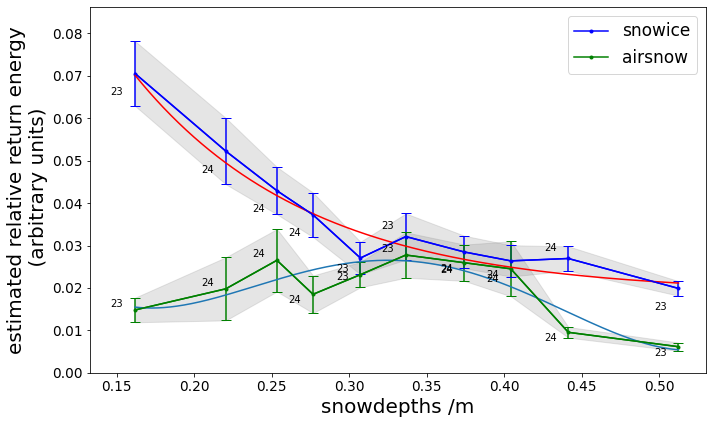

In [166]:
fig = plt.figure(figsize=(10,10/(10/6)))

snowdepth_percs_snowice,snow_ice_stds_for_snowdepth_deciles = nthTupleBoxPlotter(footprints_insitu_snowdepths,snowice_stds_within_5m,\
                                                                                 10,percentiles=True)
snowdepth_percs_airsnow,air_snow_stds_for_snowdepth_deciles = nthTupleBoxPlotter(footprints_insitu_snowdepths,airsnow_stds_within_5m,\
                                                                                 10,percentiles=True)
snowdepth_percs_snowice,snow_ice_powers_for_snowdepth_deciles = nthTupleBoxPlotter(footprints_insitu_snowdepths,snowice_interp_unlog_amps,\
                                                                                   10, percentiles=True)
snowdepth_percs_airsnow,air_snow_powers_for_snowdepth_deciles = nthTupleBoxPlotter(footprints_insitu_snowdepths,airsnow_interp_unlog_amps,\
                                                                                   10, percentiles=True)
means_of_snowice_stds_for_snowdepth_deciles = [np.mean(decile) for decile in snow_ice_stds_for_snowdepth_deciles]
means_of_airsnow_stds_for_snowdepth_deciles = [np.mean(decile) for decile in air_snow_stds_for_snowdepth_deciles]
stes_of_snowice_stds_for_snowdepth_deciles = [np.std(decile,ddof=1)/np.sqrt(len(decile)) for decile in snow_ice_stds_for_snowdepth_deciles]
stes_of_airsnow_stds_for_snowdepth_deciles = [np.std(decile,ddof=1)/np.sqrt(len(decile)) for decile in air_snow_stds_for_snowdepth_deciles]

means_of_snow_ice_power_deciles = [np.mean(decile) for decile in snow_ice_powers_for_snowdepth_deciles] 
means_of_air_snow_power_deciles = [np.mean(decile) for decile in air_snow_powers_for_snowdepth_deciles]
stes_of_snow_ice_power_deciles = [np.std(decile,ddof=1)/np.sqrt(len(decile)) for decile in snow_ice_powers_for_snowdepth_deciles] 
stes_of_air_snow_power_deciles = [np.std(decile,ddof=1)/np.sqrt(len(decile)) for decile in air_snow_powers_for_snowdepth_deciles] 
print(means_of_snowice_stds_for_snowdepth_deciles)
#removing the effect of the random uncertainty of the altitude of ATM laser spot data (=0.04756 m):
actual_means_of_snow_ice_stds_for_snowdepth_deciles = list(map(reverseErrorPropagating, means_of_snowice_stds_for_snowdepth_deciles, \
                                                               np.ones(10)*0.047561193890572354))
actual_means_of_air_snow_stds_for_snowdepth_deciles = list(map(reverseErrorPropagating, means_of_airsnow_stds_for_snowdepth_deciles, \
                                                               np.ones(10)*0.047561193890572354))
"""add the std onto the mean and then apply the negative subtraction and then subtract this from the mean"""

actual_stes_of_snow_ice_stds_for_snowdepth_deciles = list(map(lambda a,b:a-b, list(map(reverseErrorPropagating, list(map(lambda a,b:a+b,means_of_snowice_stds_for_snowdepth_deciles,stes_of_snowice_stds_for_snowdepth_deciles)), \
                                                               np.ones(10)*0.047561193890572354)), actual_means_of_snow_ice_stds_for_snowdepth_deciles))
actual_stes_of_air_snow_stds_for_snowdepth_deciles = list(map(lambda a,b:a-b, list(map(reverseErrorPropagating, list(map(lambda a,b:a+b,means_of_airsnow_stds_for_snowdepth_deciles,stes_of_airsnow_stds_for_snowdepth_deciles)), \
                                                               np.ones(10)*0.047561193890572354)), actual_means_of_air_snow_stds_for_snowdepth_deciles))
print(len(actual_stes_of_air_snow_stds_for_snowdepth_deciles))
#calculating the time that the radar travels over each interface, multiplied by c (remember time = distance/speed)
#it takes longer to for light (and radar) to travel across 1cm of snow-ice interface compared to air-snow interface,
#due to the refractive index of snow (taken as 1.238 in line with the ECCC in situ data) compared to the refractive index of air
actual_means_of_snow_ice_timeDotCs_for_snowdepth_deciles = np.array(actual_means_of_snow_ice_stds_for_snowdepth_deciles)*1.238
actual_means_of_air_snow_timeDotCs_for_snowdepth_deciles = actual_means_of_air_snow_stds_for_snowdepth_deciles
actual_stes_of_snow_ice_timeDotCs_for_snowdepth_deciles = np.array(actual_stes_of_snow_ice_stds_for_snowdepth_deciles)*1.238
actual_stes_of_air_snow_timeDotCs_for_snowdepth_deciles = actual_stes_of_air_snow_stds_for_snowdepth_deciles

errorPlot(snowdepth_percs_snowice,\
          list(map(lambda a,b:a*b, actual_means_of_snow_ice_timeDotCs_for_snowdepth_deciles,means_of_snow_ice_power_deciles)),\
          np.array(actual_stes_of_snow_ice_timeDotCs_for_snowdepth_deciles)*np.array(list(map(lambda a,b:a+b,means_of_snow_ice_power_deciles, stes_of_snow_ice_power_deciles))),\
          point_labels=[len(a) for a in snow_ice_stds_for_snowdepth_deciles], colour='blue', label= 'snowice')
errorPlot(snowdepth_percs_airsnow,\
          list(map(lambda a,b:a*b, actual_means_of_air_snow_timeDotCs_for_snowdepth_deciles,means_of_air_snow_power_deciles)),\
          np.array(actual_stes_of_air_snow_timeDotCs_for_snowdepth_deciles)*np.array(list(map(lambda a,b:a+b,means_of_air_snow_power_deciles, stes_of_air_snow_power_deciles))),\
          point_labels=[len(a) for a in air_snow_stds_for_snowdepth_deciles], colour='green', label= 'airsnow')
plt.legend(loc='best', prop={'size':17})
plt.xlabel("snowdepths /m", fontsize=20)
plt.xticks(fontsize=13.7)
plt.yticks(fontsize=13.7)
plt.ylabel("estimated relative return energy\n (arbitrary units)", fontsize=20)
plt.ylim(0,(np.max(list(map(lambda a,b:a*b, actual_means_of_snow_ice_timeDotCs_for_snowdepth_deciles,means_of_snow_ice_power_deciles)))\
         + np.max(np.array(actual_stes_of_snow_ice_timeDotCs_for_snowdepth_deciles)*np.array(list(map(lambda a,b:a+b,means_of_snow_ice_power_deciles, stes_of_snow_ice_power_deciles)))))*1.1)

from scipy import optimize
def func(x, ym, y0, k): #top estimate, bottom estimate, 1/(decay length on x-axis)
    return ym - (ym-y0) * np.exp(-k * x)
popt_snowice, pcov_snowice = optimize.curve_fit(func, snowdepth_percs_snowice, \
                                list(map(lambda a,b:a*b, actual_means_of_snow_ice_timeDotCs_for_snowdepth_deciles,means_of_snow_ice_power_deciles)),\
                                p0=[0.25,0.04,1/0.3],\
                                sigma = np.array(actual_stes_of_snow_ice_timeDotCs_for_snowdepth_deciles)*np.array(list(map(lambda a,b:a+b,means_of_snow_ice_power_deciles, stes_of_snow_ice_power_deciles))))
print("popt_snowice:",popt_snowice)
plt.plot(np.linspace(np.min(snowdepth_percs_snowice), np.max(snowdepth_percs_snowice), 1000),\
         func(np.linspace(np.min(snowdepth_percs_snowice), np.max(snowdepth_percs_snowice), 1000), *popt_snowice), c='r')
p = np.poly1d(np.polyfit(snowdepth_percs_airsnow,\
           list(map(lambda a,b:a*b, actual_means_of_air_snow_timeDotCs_for_snowdepth_deciles,means_of_air_snow_power_deciles)), deg=4))
print(p)
plt.plot(np.linspace(np.min(snowdepth_percs_airsnow),np.max(snowdepth_percs_airsnow),1000), p(np.linspace(np.min(snowdepth_percs_airsnow),np.max(snowdepth_percs_airsnow),1000)))

plt.tight_layout()
if saving:
    pass
    plt.savefig("../../Thesis/graphics/EstimatedReturnEnergiesAgainstSnowdepthsAirsnowAndSnowice"+str(icetype).upper()+"v2.png",dpi=200)


[0.16193916666666663, 0.22045471428571428, 0.25343809523809524, 0.27675, 0.3072963857142857, 0.3366205833333333, 0.37433115, 0.40430544871794877, 0.44142857142857134, 0.5124696666666667]


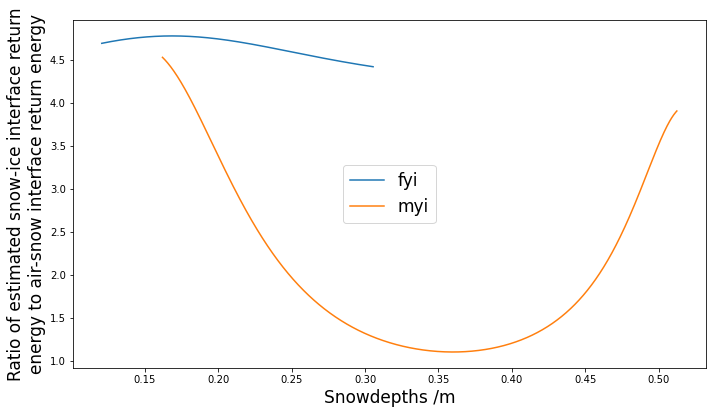

In [174]:
exec(str(icetype)+"_snowdepth_percs_snowice = snowdepth_percs_snowice")
exec(str(icetype)+"_snowdepth_percs_airsnow = snowdepth_percs_airsnow")
exec(str(icetype)+"_popt_snowice = popt_snowice")
exec(str(icetype)+"_popt_airsnow = popt_airsnow")
fig = plt.figure(figsize=(10,10/(10/6)))
print(snowdepth_percs_airsnow)
plt.plot(np.linspace(np.min(fyi_snowdepth_percs_snowice), np.max(fyi_snowdepth_percs_snowice), 1000), \
        func(np.linspace(np.min(fyi_snowdepth_percs_snowice), np.max(fyi_snowdepth_percs_snowice), 1000), *fyi_popt_snowice)/\
        func(np.linspace(np.min(fyi_snowdepth_percs_airsnow), np.max(fyi_snowdepth_percs_airsnow), 1000), *fyi_popt_airsnow), label='fyi')
plt.plot(np.linspace(np.min(myi_snowdepth_percs_snowice), np.max(myi_snowdepth_percs_snowice), 1000), \
        func(np.linspace(np.min(myi_snowdepth_percs_snowice), np.max(myi_snowdepth_percs_snowice), 1000), *myi_popt_snowice)/\
        p(np.linspace(np.min(myi_snowdepth_percs_airsnow), np.max(myi_snowdepth_percs_airsnow), 1000)), label='myi')
plt.legend(loc='center', prop ={'size':17})
plt.xlabel("Snowdepths /m", fontsize=17)
plt.ylabel("Ratio of estimated snow-ice interface return\nenergy to air-snow interface return energy", fontsize=17)
plt.tight_layout()
plt.savefig("../../Thesis/graphics/RatioofEnergiesFYIandMYI.png", dpi=200)
# plt.ylim(0,5)

In [ ]:
snowdepth_percs_snowice,snow_ice_roughnesses = nthTupleBoxPlotter(footprints_insitu_snowdepths,snowice_stds_within_5m, 10, percentiles=True)
snowdepth_percs_airsnow,air_snow_roughnesses = nthTupleBoxPlotter(footprints_insitu_snowdepths,airsnow_stds_within_5m, 10, percentiles=True)

fig = plt.figure(figsize=(6,5))
y_vals = [np.mean(ret) for ret in snow_ice_roughnesses]
y_errs = [np.std(ret,ddof=1)/np.sqrt(len(ret)) for ret in snow_ice_roughnesses]
point_labels = [len(ret) for ret in snow_ice_roughnesses]
errorPlot(snowdepth_percs_snowice,y_vals,y_errs, point_labels, colour='blue', label= 'snowice')

y_vals = [np.mean(ret) for ret in air_snow_roughnesses]
y_errs = [np.std(ret,ddof=1)/np.sqrt(len(ret)) for ret in air_snow_roughnesses]
point_labels = [len(ret) for ret in air_snow_roughnesses]
errorPlot(snowdepth_percs_airsnow,y_vals,y_errs, point_labels, colour='green',label='airsnow')

plt.legend(loc='best', prop={'size':17})
plt.xlabel("snowdepths /m", fontsize=17)
plt.ylabel("standard deviation\nover 5m radius /m", fontsize=17)
plt.ylim(0.05,0.1)
plt.tight_layout()
# plt.savefig("../Thesis/graphics/RoughnessAgainstSnowdepthsAirsnowAndSnowice"+str(icetype).upper()+".png",dpi=200)
plt.show()

In [ ]:
airsnow_stds_percs_snowice,snow_ice_energies = nthTupleBoxPlotter(actual_airsnow_stds,snowice_interp_unlog_amps*(actual_snowice_stds)*1.238, 10, percentiles=True)
airsnow_stds_percs_airsnow,air_snow_energies = nthTupleBoxPlotter(actual_airsnow_stds,airsnow_interp_unlog_amps*(actual_airsnow_stds), 10, percentiles=True)

fig = plt.figure(figsize=(6,5))
y_vals = [np.mean(ret) for ret in snow_ice_energies]
y_errs = [np.std(ret,ddof=1)/np.sqrt(len(ret)) for ret in snow_ice_energies]
point_labels = [len(ret) for ret in snow_ice_energies]
errorPlot(airsnow_stds_percs_snowice,y_vals,y_errs, point_labels, colour='blue', label= 'snowice')


y_vals = [np.mean(ret) for ret in air_snow_energies]
y_errs = [np.std(ret,ddof=1)/np.sqrt(len(ret)) for ret in air_snow_energies]
point_labels = [len(ret) for ret in air_snow_energies]
errorPlot(airsnow_stds_percs_airsnow,y_vals,y_errs, point_labels, colour='green',label='airsnow')

plt.legend(loc='best', prop={'size':17})
plt.xlabel("airsnow standard deviation over 5m radius $/m$", fontsize=17)
plt.ylabel("estimated relative return energy", fontsize=17)
plt.ylim(0,0.20)
# speary = spearmanr(snowdepth_percs,snow_ice_energies)
# plt.title("Spearman correlation: "+str(std_notation(speary[0],3))+"\np-value: "+str(std_notation(speary[1],3)), fontsize=17)
plt.tight_layout()
plt.savefig("../Thesis/graphics/EstimatedReturnEnergiesAgainstAirsnowRoughnessAirsnowAndSnowice"+str(icetype).upper()+".png",dpi=200)
plt.show()

In [ ]:
snowice_stds_percs,airsnow_stds = nthTupleBoxPlotter(snowice_stds_within_5m,airsnow_stds_within_5m, 10, percentiles=True)

fig = plt.figure(figsize=(6,5))
y_vals = [np.mean(ret) for ret in airsnow_stds]
y_errs = [np.std(ret,ddof=1)/np.sqrt(len(ret)) for ret in airsnow_stds]
point_labels = [len(ret) for ret in airsnow_stds]
errorPlot(snowice_stds_percs,y_vals,y_errs, point_labels, colour='blue')

plt.legend(loc='best', prop={'size':17})
plt.xlabel("snowice interface standard \ndeviation over 5m radius $/m$", fontsize=17)
plt.ylabel("airsnow interface standard \ndeviation over 5m radius $/m$", fontsize=17)
plt.ylim(0.04,0.091)

speary = spearmanr(snowice_stds_within_5m,airsnow_stds_within_5m)
plt.title("Spearman correlation: "+str(std_notation(speary[0],3))+"\np-value: "+str(std_notation(speary[1],3)), fontsize=17)
plt.tight_layout()
plt.savefig("../Thesis/graphics/AirsnowRoughnessAgainstSnowiceRoughness"+str(icetype).upper()+".png",dpi=200)
plt.show()

In [ ]:
airsnow_stds_percs,snowice_stds = nthTupleBoxPlotter(airsnow_stds_within_5m,snowice_stds_within_5m, 10, percentiles=True)

fig = plt.figure(figsize=(6,5))
y_vals = [np.mean(ret) for ret in snowice_stds]
y_errs = [np.std(ret,ddof=1)/np.sqrt(len(ret)) for ret in snowice_stds]
point_labels = [len(ret) for ret in snowice_stds]
errorPlot(airsnow_stds_percs,y_vals,y_errs, point_labels, colour='blue')

plt.legend(loc='best', prop={'size':17})
plt.ylabel("snowice interface standard \ndeviation over 5m radius $/m$", fontsize=17)
plt.xlabel("airsnow interface standard \ndeviation over 5m radius $/m$", fontsize=17)
# plt.ylim(0.05,0.071)

speary = spearmanr(airsnow_stds_within_5m,snowice_stds_within_5m)
plt.title("Spearman correlation: "+str(std_notation(speary[0],3))+"\np-value: "+str(std_notation(speary[1],3)), fontsize=17)
plt.tight_layout()
plt.savefig("../Thesis/graphics/AirsnowRoughnessAgainstSnowiceRoughness"+str(icetype).upper()+".png",dpi=200)
plt.show()

In [ ]:
def errorPlot(x_vals,y_vals,y_errs,point_labels=False, fill_between_errorbars = True, annotate=True, label=False, colour='red'):
    if label:
        line, = plt.plot(x_vals,y_vals,color=colour, linestyle = '-', marker='.', label=label)
    else:
        line, = plt.plot(x_vals,y_vals,color=colour, linestyle = '-', marker = '.')
    plt.errorbar(x_vals,y_vals, yerr=y_errs, capthick=1,capsize=5, ecolor=colour, color=colour)
    #make sure that you've already filtered out all nan data that might contribute to the point_label number values
    if annotate and np.any(point_labels):
        for i, txt in enumerate(point_labels):
            if i==0:
                if y_vals[i+1]>y_vals[i]:
                    plt.annotate(str(int(txt)), (x_vals[i] - (np.nanmax(x_vals)-np.nanmin(x_vals))/50 - len(str(txt))*(np.nanmax(x_vals)-np.nanmin(x_vals))/80, \
                                       [np.nanmean(y_val) for y_val in y_vals][i]+(np.nanmax(y_vals)-np.nanmin(y_vals))/30))
                else:
                    plt.annotate(str(int(txt)), (x_vals[i] - (np.nanmax(x_vals)-np.nanmin(x_vals))/50 - len(str(txt))*(np.nanmax(x_vals)-np.nanmin(x_vals))/80, \
                                       [np.nanmean(y_val) for y_val in y_vals][i]-(np.nanmax(y_vals)-np.nanmin(y_vals))/10))
            elif y_vals[i]> y_vals[i-1]:
                plt.annotate(str(int(txt)), (x_vals[i] - (np.nanmax(x_vals)-np.nanmin(x_vals))/50 - len(str(txt))*(np.nanmax(x_vals)-np.nanmin(x_vals))/80, \
                                   [np.nanmean(y_val) for y_val in y_vals][i]+(np.nanmax(y_vals)-np.nanmin(y_vals))/30))
            else:
                plt.annotate(str(int(txt)), (x_vals[i] - (np.nanmax(x_vals)-np.nanmin(x_vals))/50 - len(str(txt))*(np.nanmax(x_vals)-np.nanmin(x_vals))/80, \
                                   [np.nanmean(y_val) for y_val in y_vals][i]-(np.nanmax(y_vals)-np.nanmin(y_vals))/10))
    plt.xlim(np.nanmin(x_vals)-(np.nanmax(x_vals)-np.nanmin(x_vals))/12,)
    plt.ylim(np.nanmin(y_vals)-np.nanmax(y_errs) - (np.nanmax(y_vals)-np.nanmin(y_vals))/12, \
             np.nanmax(y_vals)+np.nanmax(y_errs) + (np.nanmax(y_vals)-np.nanmin(y_vals))/12) 
    if fill_between_errorbars:
        plt.fill_between(x_vals, np.subtract(y_vals,y_errs, where=~np.isnan(np.array(y_vals)+np.array(y_errs))), \
                         np.add(y_vals,y_errs,where=~np.isnan(np.array(y_vals)+np.array(y_errs))), color='gray', alpha=0.2)

In [ ]:
#finding the relation between the correlation of the two interfaces and properties such as 

plt.scatter(airsnow_stds_within_5m, snowice_interp_unlog_amps)
plt.scatter(airsnow_stds_within_5m, snowice_interp_unlog_amps)
plt.show()

plt.scatter(snowice_stds_within_5m, snowice_interp_unlog_amps)

In [ ]:
airsnow_stds_within_5m_myi = airsnow_stds_within_5m
snowice_stds_within_5m_myi = snowice_stds_within_5m
snowice_interp_unlog_amps_myi = snowice_interp_unlog_amps
airsnow_interp_unlog_amps_myi = airsnow_interp_unlog_amps

In [ ]:
plt.hist(snowice_stds_within_5m, bins = np.linspace(0,0.15,40))
plt.xlabel("snowice stds within 5 m", fontsize=17)
plt.ylabel("Frequency", fontsize=17)